<p align="center">
  <img src="https://file+.vscode-resource.vscode-cdn.net/c%3A/Users/DEEPMALYA/OneDrive/Desktop/pip_Malya/Astronomy/Aries/Version01//media/banner.png?version%3D1764056746359" alt="Cosmic Anomaly Detection Banner" />
</p>

*“We present a modular, ML-based anomaly detection pipeline applied to a localized Gaia DR3 field, visualized through an interactive ipyaladin interface. Using unsupervised ML on astrometric and photometric features, we identify subtle stellar outliers such as motion anomalies, rare color–magnitude objects, or DR2→DR3 brightness discrepancies. The system is designed for extensibility but implemented with a streamlined, computationally efficient architecture ideal for research, education, and future large-scale integration.”*

In [3]:
# STEP 1: Basic environment setup and sanity checks

import numpy as np
import pandas as pd

from astropy.coordinates import SkyCoord
import astropy.units as u

from astroquery.gaia import Gaia
from ipyaladin import Aladin
import ipywidgets

# Turn off warnings to keep notebook clean
import warnings
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")

# Gaia connection test:
try:
    test_job = Gaia.launch_job_async("SELECT TOP 1 source_id FROM gaiadr3.gaia_source")
    test_res = test_job.get_results()
    print("Gaia Archive Connection: OK")
except Exception as e:
    print("Gaia Archive Connection FAILED:", e)


Libraries imported successfully!
INFO: Query finished. [astroquery.utils.tap.core]
Gaia Archive Connection: OK


In [4]:
center=SkyCoord(ra=359.944236*u.rad, dec=-0.04616001*u.rad)

In [5]:
# STEP 3: Mini Gaia DR3 query test (TOP 200 sources) - training dataset

# Define a small search radius to avoid big queries
radius = 0.1 * u.deg   # 0.1° radius around center; very small for safety

adql_query = f"""
SELECT TOP 200
    source_id, ra, dec, parallax, pmra, pmdec,
    phot_g_mean_mag, bp_rp
FROM gaiadr3.gaia_source
WHERE CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', {center.ra.deg}, {center.dec.deg}, {radius.to(u.deg).value})
)=1
"""

print("Running Gaia DR3 test query...")
job = Gaia.launch_job_async(adql_query)
results = job.get_results()

print(f"Rows returned: {len(results)}")

# Convert to pandas df
df_dr3_small = results.to_pandas()
df_dr3_small.head()


Running Gaia DR3 test query...
INFO: Query finished. [astroquery.utils.tap.core]
Rows returned: 200


,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,bp_rp
0,3105956285014613504,103.303428,-2.689122,NaN,NaN,NaN,20.356379,NaN
1,3105944254808551680,103.337499,-2.719192,-0.063165,-0.322608,-0.013907,17.711933,2.116507
2,3105943773774523008,103.320492,-2.738481,3.304434,-24.113468,-19.937400,19.865221,3.022654
3,3105943808131894784,103.298457,-2.742497,1.792715,-0.827515,-1.573063,18.697275,2.642706
4,3105943808131902720,103.307529,-2.739777,0.000237,-1.492899,1.783094,18.487164,1.535589


In [6]:
 # STEP 4: Mini Gaia DR2 query test (same region, same features) - testing dataset

adql_query_dr2 = f"""
SELECT TOP 200
    source_id, ra, dec, parallax, pmra, pmdec,
    phot_g_mean_mag, bp_rp
FROM gaiadr2.gaia_source
WHERE CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', {center.ra.deg}, {center.dec.deg}, {radius.to(u.deg).value})
)=1
"""

print("Running Gaia DR2 test query...")
job2 = Gaia.launch_job_async(adql_query_dr2)
results2 = job2.get_results()

print(f"Rows returned (DR2): {len(results2)}")

# Convert to pandas
df_dr2_small = results2.to_pandas()
df_dr2_small.head()


Running Gaia DR2 test query...
INFO: Query finished. [astroquery.utils.tap.core]
Rows returned (DR2): 200


,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,bp_rp
0,3105967039612396544,103.314945,-2.555706,0.733699,1.144773,-3.383944,19.946505,1.633446
1,3105957139710572160,103.262323,-2.673470,-0.024125,0.462018,0.638647,17.055614,0.959578
2,3105956967911880448,103.242565,-2.672898,1.444968,1.235800,-1.043418,18.722492,2.216032
3,3105944224746494592,103.328591,-2.728817,NaN,NaN,NaN,21.056353,NaN
4,3105966558576177408,103.291365,-2.588322,0.762046,-0.503749,0.630827,18.853266,1.646488


In [7]:
# merge the common stars data
merged = df_dr2_small.merge(df_dr3_small, on="source_id", suffixes=("_dr2","_dr3"))

In [8]:
merged.sample(10)

,source_id,ra_dr2,dec_dr2,parallax_dr2,pmra_dr2,pmdec_dr2,phot_g_mean_mag_dr2,bp_rp_dr2,ra_dr3,dec_dr3,parallax_dr3,pmra_dr3,pmdec_dr3,phot_g_mean_mag_dr3,bp_rp_dr3
13,3105955494744786176,103.264142,-2.738923,1.213859,2.626404,2.026425,13.937350,0.778083,103.264142,-2.738923,1.165990,2.524266,1.978907,13.927050,0.768078
1,3105944220448783104,103.323499,-2.730845,-0.714013,0.490676,0.652393,19.832394,1.601849,103.323499,-2.730845,-0.703025,-0.547699,0.209970,19.774035,1.492956
0,3105944224746494592,103.328591,-2.728817,NaN,NaN,NaN,21.056353,NaN,103.328589,-2.728817,NaN,NaN,NaN,20.950546,NaN
14,3105955529100570112,103.264873,-2.733908,NaN,NaN,NaN,19.254017,1.446217,103.264873,-2.733908,-0.154703,-0.872906,0.793264,19.199190,1.600563
4,3105954292150050304,103.228183,-2.725205,NaN,NaN,NaN,21.151218,NaN,103.228188,-2.725204,NaN,NaN,NaN,21.044304,1.161007
5,3105944259110247552,103.342877,-2.714055,0.591171,-1.427241,-2.854104,16.657160,1.071550,103.342877,-2.714055,0.525474,-1.435313,-2.784983,16.642567,1.060539
15,3105955529100569088,103.265898,-2.734498,NaN,NaN,NaN,19.320829,1.430592,103.265898,-2.734498,0.026931,1.778367,-0.185193,19.257730,1.631769
7,3105944254809854336,103.333389,-2.715321,-0.390974,0.481175,0.030538,19.391743,1.540375,103.333389,-2.715321,-0.320197,0.064872,0.120595,19.348425,1.699799
3,3105955563464226688,103.293033,-2.727560,0.040624,-1.232021,0.264193,18.932983,1.277405,103.293033,-2.727560,0.081144,-1.655898,0.508555,18.894756,1.570589
9,3105944362185361792,103.341227,-2.703072,1.258275,1.732199,2.361208,20.664986,1.837383,103.341226,-2.703072,-1.187768,-1.384740,-1.352154,20.591358,2.192230


In [9]:
print("Number of common stars ->",len(merged))

Number of common stars -> 17


In [10]:
# 2. Stars present only in DR2 (VANISHED stars)
dr2_only = df_dr2_small[~df_dr2_small["source_id"].isin(df_dr3_small["source_id"])]
print("Stars ONLY in DR2 (vanished):", len(dr2_only))

# 3. Stars present only in DR3 (NEW appearances)
dr3_only = df_dr3_small[~df_dr3_small["source_id"].isin(df_dr2_small["source_id"])]
print("Stars ONLY in DR3 (new):", len(dr3_only))



Stars ONLY in DR2 (vanished): 183
Stars ONLY in DR3 (new): 183


In [11]:
print("Missing % from col. - ")
merged.isnull().sum() * 100 / len(merged)

Missing % from col. - 


source_id               0.000000
ra_dr2                  0.000000
dec_dr2                 0.000000
parallax_dr2           29.411765
pmra_dr2               29.411765
pmdec_dr2              29.411765
phot_g_mean_mag_dr2     0.000000
bp_rp_dr2              11.764706
ra_dr3                  0.000000
dec_dr3                 0.000000
parallax_dr3           11.764706
pmra_dr3               11.764706
pmdec_dr3              11.764706
phot_g_mean_mag_dr3     0.000000
bp_rp_dr3               5.882353
dtype: float64

#### Here we have missing values, but unlike in regular datasets where we either drop the columns with mising values or impute them - here we don't do the same.In astronomy this is statistically wrong - because:

* parallax ≠ normally distributed

* pmra/pmdec ≠ symmetric

* color/magnitude ≠ normal variables

* Gaia missing values are not random but physically meaningful

* Imputing means inventing fake astrophysical measurements

* This destroys anomaly detection.

We treat missing values as information.

✔ If a measurement exists in DR3 but NOT in DR2 → anomaly candidate

✔ If a measurement exists in DR2 but NOT in DR3 → anomaly candidate

✔ For measurements missing in both → simply exclude from that specific Δ-feature

In [12]:
# STEP 6B — Proper missing value handling for Gaia DR2/DR3

df = merged.copy()

# ---- Create missingness indicators ---- #
for col in ["parallax", "pmra", "pmdec", "phot_g_mean_mag", "bp_rp"]:
    df[f"missing_{col}_dr2"] = df[f"{col}_dr2"].isna().astype(int)
    df[f"missing_{col}_dr3"] = df[f"{col}_dr3"].isna().astype(int)

# ---- Compute Δ-features only when both values exist ---- #

def safe_diff(col):
    col_dr2 = f"{col}_dr2"
    col_dr3 = f"{col}_dr3"
    diff = df[col_dr3] - df[col_dr2]
    # keep NaN where either side missing
    return diff.where(~(df[col_dr3].isna() | df[col_dr2].isna()))

df["d_mag"]      = safe_diff("phot_g_mean_mag")
df["d_color"]    = safe_diff("bp_rp")
df["d_pmra"]     = safe_diff("pmra")
df["d_pmdec"]    = safe_diff("pmdec")
df["d_parallax"] = safe_diff("parallax")

# ---- Summary of missingness & diffs ---- #
print("Missingness summary:")
print(df.filter(like="missing").sum())

print("\nΔ-feature summary:")
print(df[["d_mag", "d_color", "d_pmra", "d_pmdec", "d_parallax"]].describe())

df.head()


Missingness summary:
missing_parallax_dr2           5
missing_parallax_dr3           2
missing_pmra_dr2               5
missing_pmra_dr3               2
missing_pmdec_dr2              5
missing_pmdec_dr3              2
missing_phot_g_mean_mag_dr2    0
missing_phot_g_mean_mag_dr3    0
missing_bp_rp_dr2              2
missing_bp_rp_dr3              1
dtype: int64

Δ-feature summary:
           d_mag    d_color     d_pmra    d_pmdec  d_parallax
count  17.000000  15.000000  12.000000  12.000000   12.000000
mean   -0.055617   0.154766  -0.448936  -0.403516   -0.242407
std     0.031316   0.279949   1.260765   1.114877    0.780079
min    -0.106915  -0.126057  -3.116939  -3.713362   -2.446043
25%    -0.073627  -0.013592  -0.577502  -0.530115   -0.180708
50%    -0.054827   0.051041  -0.060949  -0.014396   -0.002665
75%    -0.033966   0.247181   0.332872   0.088497    0.111168
max    -0.010301   0.968218   0.996047   0.509200    0.391059


,source_id,ra_dr2,dec_dr2,parallax_dr2,pmra_dr2,pmdec_dr2,phot_g_mean_mag_dr2,bp_rp_dr2,ra_dr3,dec_dr3,...,missing_pmdec_dr3,missing_phot_g_mean_mag_dr2,missing_phot_g_mean_mag_dr3,missing_bp_rp_dr2,missing_bp_rp_dr3,d_mag,d_color,d_pmra,d_pmdec,d_parallax
0,3105944224746494592,103.328591,-2.728817,NaN,NaN,NaN,21.056353,NaN,103.328589,-2.728817,...,1,0,0,1,1,-0.105806,NaN,NaN,NaN,NaN
1,3105944220448783104,103.323499,-2.730845,-0.714013,0.490676,0.652393,19.832394,1.601849,103.323499,-2.730845,...,0,0,0,0,0,-0.058359,-0.108892,-1.038374,-0.442424,0.010988
2,3105943846793437952,103.307586,-2.734595,0.384221,0.191938,1.154227,18.883081,1.604345,103.307586,-2.734595,...,0,0,0,0,0,-0.033966,-0.126057,0.411954,0.087977,0.342400
3,3105955563464226688,103.293033,-2.727560,0.040624,-1.232021,0.264193,18.932983,1.277405,103.293033,-2.727560,...,0,0,0,0,0,-0.038227,0.293184,-0.423877,0.244362,0.040520
4,3105954292150050304,103.228183,-2.725205,NaN,NaN,NaN,21.151218,NaN,103.228188,-2.725204,...,1,0,0,1,0,-0.106915,NaN,NaN,NaN,NaN


In [13]:
df.shape

(17, 30)

#### Before we define anomalies let's look at the distribution visually 

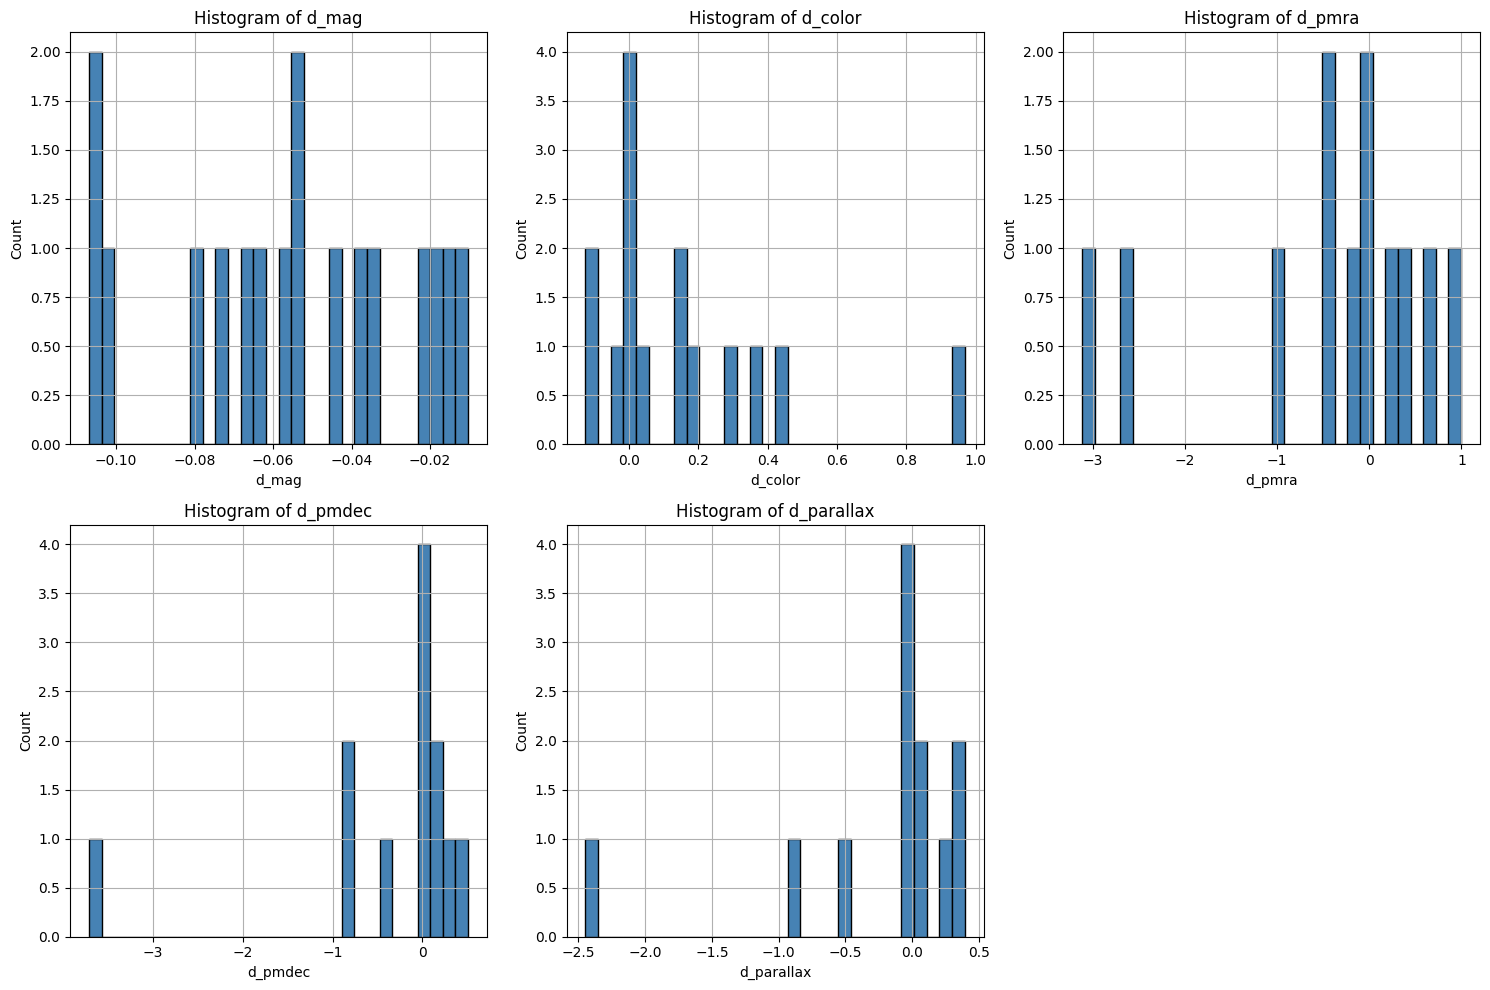


Statistical Summary:
           d_mag    d_color     d_pmra    d_pmdec  d_parallax
count  17.000000  15.000000  12.000000  12.000000   12.000000
mean   -0.055617   0.154766  -0.448936  -0.403516   -0.242407
std     0.031316   0.279949   1.260765   1.114877    0.780079
min    -0.106915  -0.126057  -3.116939  -3.713362   -2.446043
25%    -0.073627  -0.013592  -0.577502  -0.530115   -0.180708
50%    -0.054827   0.051041  -0.060949  -0.014396   -0.002665
75%    -0.033966   0.247181   0.332872   0.088497    0.111168
max    -0.010301   0.968218   0.996047   0.509200    0.391059


In [14]:
# STEP 7: Visual sanity checks — Histograms of Δ-features

import matplotlib.pyplot as plt

change_cols = ["d_mag", "d_color", "d_pmra", "d_pmdec", "d_parallax"]

plt.figure(figsize=(15, 10))

for i, col in enumerate(change_cols, 1):
    plt.subplot(2, 3, i)
    df[col].dropna().hist(bins=30, color='steelblue', edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Print mean + std for quick inspection
print("\nStatistical Summary:")
print(df[change_cols].describe())


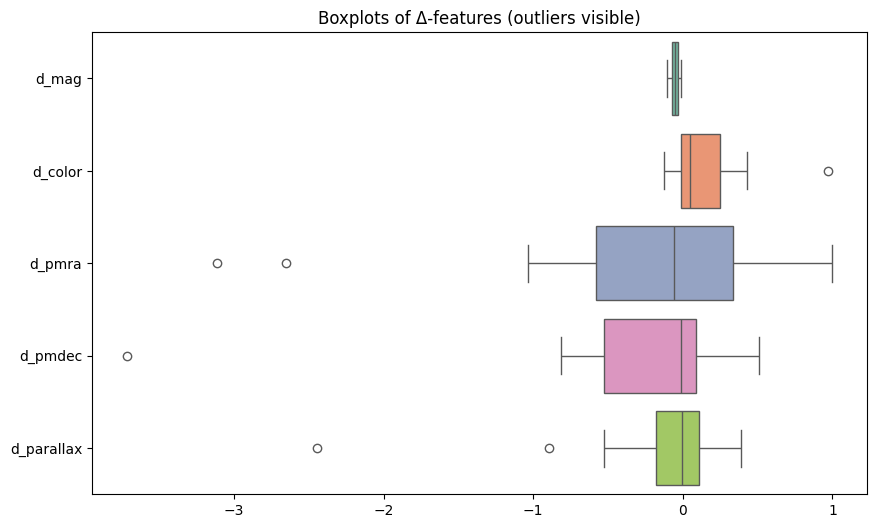

In [15]:
# 2. Boxplots
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=df[change_cols], orient="h", palette="Set2")
plt.title("Boxplots of Δ-features (outliers visible)")
plt.show()

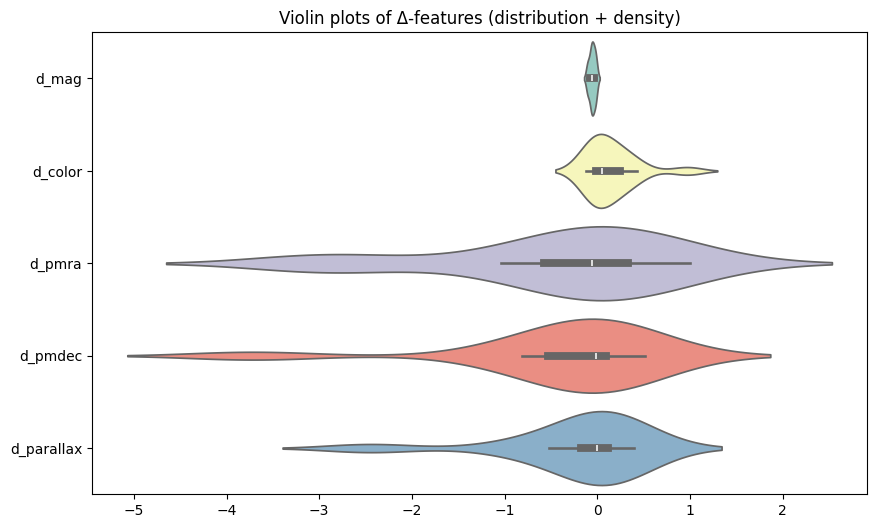

In [16]:
# 3. Violin plots -- Combine boxplot with a kernel density estimate.Show both distribution shape and summary stats.
plt.figure(figsize=(10, 6))
sns.violinplot(data=df[change_cols], orient="h", palette="Set3")
plt.title("Violin plots of Δ-features (distribution + density)")
plt.show()

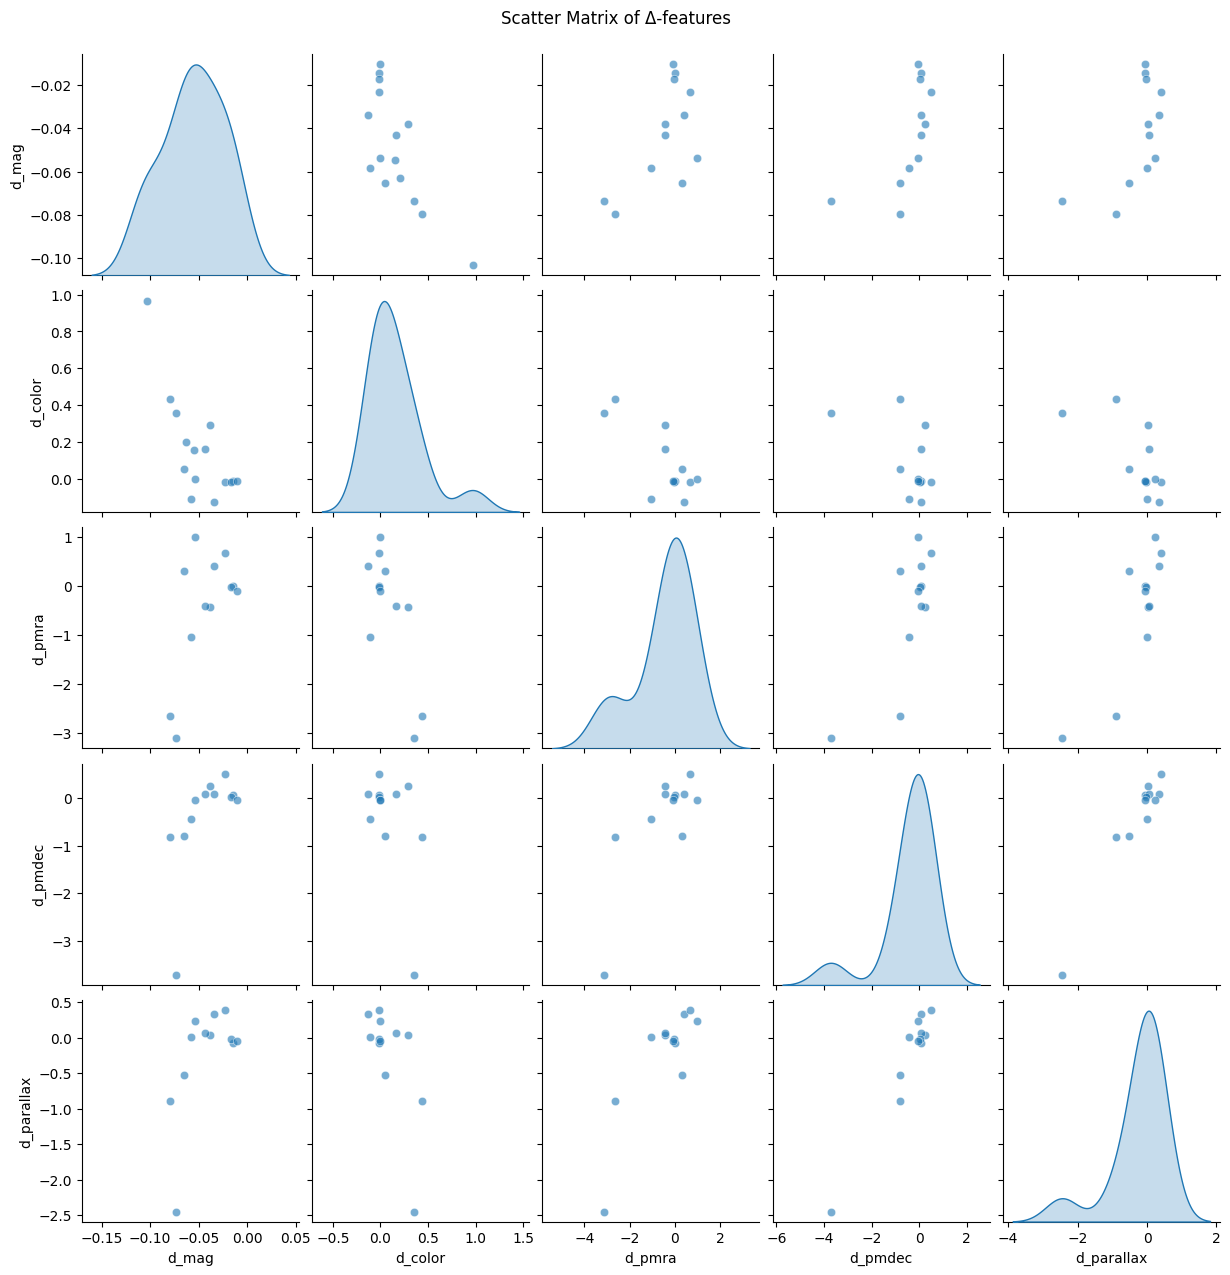

In [17]:
# 4. Scatter matrix (pairplot)
sns.pairplot(df[change_cols], diag_kind="kde", plot_kws={"alpha":0.6})
plt.suptitle("Scatter Matrix of Δ-features", y=1.02)
plt.show()

In [18]:
# STEP 8: Define anomaly rules & compute anomaly scores

df_anom = df.copy()

# ---------------------------
# Thresholds (based on histogram + astrophysical sense)
# ---------------------------

TH_MAG = 0.3        # mag change > 0.3 is unusual
TH_COLOR = 0.15     # color shift > 0.15 significant
TH_PM = 1.0         # proper motion change > 1 mas/yr = strong
TH_PAR = 0.5        # parallax change > 0.5 mas = suspicious

# ---------------------------
# Boolean anomaly labels
# ---------------------------

df_anom["anom_mag"]   = df_anom["d_mag"].abs()       > TH_MAG
df_anom["anom_color"] = df_anom["d_color"].abs()     > TH_COLOR
df_anom["anom_pm"]    = ((df_anom["d_pmra"].abs()    > TH_PM) |
                         (df_anom["d_pmdec"].abs()   > TH_PM))
df_anom["anom_par"]   = df_anom["d_parallax"].abs()  > TH_PAR

# Missing-value anomalies
df_anom["anom_missing"] = (
    df_anom.filter(like="missing")
    .sum(axis=1)
) > 0  # any missing measurement means anomaly

# ---------------------------
# Combined anomaly score (0–1 normalized)
# ---------------------------

df_anom["anom_score"] = (
    df_anom["anom_mag"].astype(int) * 0.25 +
    df_anom["anom_color"].astype(int) * 0.20 +
    df_anom["anom_pm"].astype(int) * 0.30 +
    df_anom["anom_par"].astype(int) * 0.20 +
    df_anom["anom_missing"].astype(int) * 0.05
)

# ---------------------------
# Print summary
# ---------------------------

print("Anomaly counts:")
print(df_anom[["anom_mag", "anom_color", "anom_pm", "anom_par", "anom_missing"]].sum())

print("\nTop anomalies by score:")
df_anom[["source_id", "anom_score", "d_mag", "d_color", "d_pmra", "d_pmdec", "d_parallax"]]


Anomaly counts:
anom_mag        0
anom_color      7
anom_pm         3
anom_par        3
anom_missing    5
dtype: int64

Top anomalies by score:


,source_id,anom_score,d_mag,d_color,d_pmra,d_pmdec,d_parallax
0,3105944224746494592,0.05,-0.105806,NaN,NaN,NaN,NaN
1,3105944220448783104,0.30,-0.058359,-0.108892,-1.038374,-0.442424,0.010988
2,3105943846793437952,0.00,-0.033966,-0.126057,0.411954,0.087977,0.342400
3,3105955563464226688,0.20,-0.038227,0.293184,-0.423877,0.244362,0.040520
4,3105954292150050304,0.05,-0.106915,NaN,NaN,NaN,NaN
5,3105944259110247552,0.00,-0.014593,-0.011011,-0.008073,0.069122,-0.065697
6,3105955116783770880,0.00,-0.023096,-0.016874,0.675795,0.509200,0.391059
7,3105944254809854336,0.20,-0.043318,0.159424,-0.416303,0.090057,0.070777
8,3105955563460228992,0.25,-0.103363,0.968218,NaN,NaN,NaN
9,3105944362185361792,0.70,-0.073627,0.354847,-3.116939,-3.713362,-2.446043


#### Pop Up layout of details of anomalised stars 

In [19]:
# STEP 9: Build the visualization-ready anomaly catalog for ipyaladin

# We will keep only stars that have ANY anomaly
df_vis = df_anom[df_anom["anom_score"] > 0].copy()

# ---- Assign anomaly type (priority-based) ---- #
def classify_row(row):
    if row["anom_pm"]:
        return "motion_anomaly"
    if row["anom_mag"]:
        return "brightness_change"
    if row["anom_color"]:
        return "color_shift"
    if row["anom_par"]:
        return "parallax_change"
    if row["anom_missing"]:
        return "missing_data"
    return "unknown"

df_vis["anomaly_type"] = df_vis.apply(classify_row, axis=1)

# ---- Prepare popup info ---- #
def make_popup(row):
    return (
        f"<b>Source ID:</b> {row['source_id']}<br>"
        f"<b>Anomaly Type:</b> {row['anomaly_type']}<br>"
        f"<b>Score:</b> {row['anom_score']:.2f}<br>"
        f"<b>d_mag:</b> {row['d_mag']:.3f}<br>"
        f"<b>d_color:</b> {row['d_color']:.3f}<br>"
        f"<b>d_pm:</b> ({row['d_pmra']:.3f}, {row['d_pmdec']:.3f})<br>"
        f"<b>d_parallax:</b> {row['d_parallax']:.3f}<br>"
    )

df_vis["popup"] = df_vis.apply(make_popup, axis=1)

# ---- Convert to ipyaladin-friendly format ---- #
vis_list = []

for _, r in df_vis.iterrows():
    vis_list.append({
        "ra": float(r["ra_dr3"]),
        "dec": float(r["dec_dr3"]),
        "source_id": str(r["source_id"]),
        "anomaly_type": r["anomaly_type"],
        "score": float(r["anom_score"]),
        "popup": r["popup"]
    })

# Preview the first few visualization entries
vis_list[:5]


[{'ra': 103.32858943741341,
  'dec': -2.7288167593781183,
  'source_id': '3105944224746494592',
  'anomaly_type': 'missing_data',
  'score': 0.05,
  'popup': '<b>Source ID:</b> 3105944224746494592<br><b>Anomaly Type:</b> missing_data<br><b>Score:</b> 0.05<br><b>d_mag:</b> -0.106<br><b>d_color:</b> nan<br><b>d_pm:</b> (nan, nan)<br><b>d_parallax:</b> nan<br>'},
 {'ra': 103.32349881576722,
  'dec': -2.7308453006890803,
  'source_id': '3105944220448783104',
  'anomaly_type': 'motion_anomaly',
  'score': 0.3,
  'popup': '<b>Source ID:</b> 3105944220448783104<br><b>Anomaly Type:</b> motion_anomaly<br><b>Score:</b> 0.30<br><b>d_mag:</b> -0.058<br><b>d_color:</b> -0.109<br><b>d_pm:</b> (-1.038, -0.442)<br><b>d_parallax:</b> 0.011<br>'},
 {'ra': 103.29303251881669,
  'dec': -2.7275604173184487,
  'source_id': '3105955563464226688',
  'anomaly_type': 'color_shift',
  'score': 0.2,
  'popup': '<b>Source ID:</b> 3105955563464226688<br><b>Anomaly Type:</b> color_shift<br><b>Score:</b> 0.20<br><b>d

In [20]:
from ipyaladin import Aladin
aladin=Aladin(target=f"{center.ra.deg} {center.dec.deg}",fov=0.05)
aladin

In [22]:
from ipyaladin import Marker

# Build marker list
markers = []

for obj in vis_list:
    coord = SkyCoord(ra=round(obj["ra"]*u.deg,6), dec=round(obj["dec"]*u.deg,6), frame="icrs")
    
    # The popup/info block in HTML
    popup_html = obj["popup"]

    # Convert to ipyaladin Marker object
    markers.append(
        Marker(
            position=coord,
            title=f"Anomaly: {obj['anomaly_type']}",
            description=popup_html,  # HTML allowed
        )
    )

aladin.add_markers(
    markers,
    name="Detected_Anomalies",
    color="red",
    shape="circle",
    source_size=22
)

print(f"Prepared {len(markers)} anomaly markers.")

Prepared 11 anomaly markers.



<h2 align='center>Project: ML Detection of Cosmic Anomalies at a scale of 200 stars from GAIA catalog V1.0</h2>
<h4 align="center">✨ Version 1.0 — Successfully Completed ✨</h4>

---

### ✅ Achievements (V1.0)
- 🔭 Queried Gaia DR2 & DR3 multi-epoch data  
- 🌠 Engineered Δ-features: brightness, color, motion, parallax  
- 🚩 Flagged anomalies with rule-based logic  
- 🖥️ Visualized results interactively in **ipyaladin**  
- 📊 Validated anomalies with statistical summaries  

---

### 🚀 Roadmap (V2.0)
- 🤖 ML-driven anomaly detection (Isolation Forest, Autoencoders, LOF)  
- 🔁 CI/CD pipeline for reproducibility  
- 🐳 Dockerisation for modular deployment  
- ☁️ Cloud-ready architecture  
- 🌌 Dataset upgrade: **200 → 2 Billion stars**  

---

### 🧠 Impact
Bridging **astronomy + machine learning** for scalable, real-time discovery of rare cosmic phenomena.  
From hypervelocity stars to transient supernovae — modular, reproducible, and publication-ready.  

> *“The subtle signals of the Universe await detection — and we now have the tools to hear them.”*

---

### 📌 Follow the Journey
- 🔗 [GitHub](https://github.com/yourusername/galaxy-anomaly-detection)  
- 📊 [Kaggle](https://kaggle.com/yourusername/cosmic-anomaly-detector)  
- 💼 [LinkedIn](https://linkedin.com/in/yourprofile)  

---

<p align="center">
🏁 **Final Note** — V1.0 was proof of concept.  
V2.0 will be a launchpad into scale, automation, and scientific impact.  
<br><br>
<strong>Stay curious. Stay cosmic.</strong>
</p>


> ------------------------------------------------------------------------
>
>
> ✨ *Version 1.0 — Successfully Completed* ✨
>
> With this, I proudly declare the **successful and joyful completion of Version 1.0**  — a journey that began with curiosity and culminated in a working pipeline capable of detecting faint, rare, and meaningful changes in the cosmos.
>
> ------------------------------------------------------------------------

### ✅ Achievements in Version 1.0
- 🔭 Queried and compared multi-epoch data from **Gaia DR2 and DR3**
- 🌠 Engineered Δ-features: brightness, color, motion, parallax
- 🚩 Flagged anomalies using rule-based logic
- 🖥️ Visualized results interactively with **ipyaladin** on a 3D skymap
- 📊 Validated anomalies with statistical summaries and visual sanity checks

---

### 🚀 What’s Coming in Version 2.0
- 🤖 **ML-driven anomaly detection** (Isolation Forest, Autoencoders, LOF)
- 🔁 **End-to-End CI/CD pipeline** for reproducibility and automation
- 🐳 **Dockerisation** for modular deployment
- ☁️ **Cloud-ready deployment** architecture
- 🌌 **Dataset upgrade** from 200 stars → **2 Billion** stars using HEALPix tiling and Parquet storage

---

### 🧠 Impact
This project bridges **astronomy and machine learning**, enabling scalable, real-time discovery of rare cosmic phenomena — from hypervelocity stars to transient supernovae.  
It’s modular, reproducible, and ready for publication.

> *“The subtle signals of the Universe await detection — and we now have the tools to hear them.”*

---

### 📌 Follow the Journey
- 🔗 [GitHub Repository](https://github.com/yourusername/galaxy-anomaly-detection)
- 📊 [Kaggle Notebook](https://kaggle.com/yourusername/cosmic-anomaly-detector)
- 💼 [LinkedIn Post](https://linkedin.com/in/yourprofile)

---

> ------------------------------------------------------------------------
>
> 🏁 **Final Note**  
> Version 1.0 was a proof of concept.  
> Version 2.0 will be a launchpad — into scale, automation, and scientific impact.  
>
> **Stay curious. Stay cosmic.**
>
> ------------------------------------------------------------------------
